In [121]:
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (
    AbstractValue, 
    ConstantVectorSource,
    Demultiplexer,
    DiagramBuilder,
    DifferentialInverseKinematicsIntegrator,
    DifferentialInverseKinematicsParameters,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    ModelInstanceIndex,
    MultibodyPlant,
    PassThrough,
    PiecewisePose,
    RevoluteJoint,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    StateInterpolatorWithDiscreteDerivative,
    TrajectorySource,
    AddMultibodyPlantSceneGraph,
    Parser,
)
import math
from IPython.display import SVG, display
import pydot

In [2]:
from manipulation import running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
class PoseTrajectorySource(LeafSystem):
    def __init__(self, pose_trajectory):
        LeafSystem.__init__(self)
        self._pose_trajectory = pose_trajectory
        self.DeclareAbstractOutputPort(
            "pose", lambda: AbstractValue.Make(RigidTransform()), self.CalcPose
        )
        
    def CalcPose(self, context, output):
        output.set_value(self._pose_trajectory.GetPose(context.get_time()))

In [29]:
def AddJaco(plant, collision_model="no_collision"):
    parser = Parser(plant)
    jaco = parser.AddModelsFromUrl("package://drake/manipulation/models/jaco_description/urdf/j2s7s300_arm.urdf")[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base"))
    
    # set default positions:
    q0 = [1.8, 3.44, 3.14, 0.76, 4.63, 4.49, 5.03]
    index = 0
    for joint_index in plant.GetJointIndices(jaco):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1
    return jaco

In [127]:
def MakeJacoStation(
    model_directives=None,
    filename=None,
    time_step=0.002,
    jaco_prefix="j2s7s300",
):
    """
    Creates a kinova jaco station system, which is a sub-diagram containing:
     - A MultibodyPlant with populated via the Parser from the
       `model_directives` argument AND the `filename` argument.
     - A SceneGraph
     - For each model instance starting with ``
     
    Args:
        model_directives: a string containing any model directives to be parsed
        
        filename: a string containing the name of an sdf, urdf, mujoco xml. or
        model directives yaml file.
        
        time_step: the standard MultibodyPlant time step.

    """
    builder = DiagramBuilder()
    
    # add kinova jaco arm
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=time_step
    )
    parser = Parser(plant)
    if model_directives:
        parser.AddModelsFromString(model_directives, ".dmd.yaml")
    if filename:
        parser.AddModelsFromUrl(filename)
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base"))
    plant.Finalize()
    
    for i in range(plant.num_model_instances()):
        model_instance = ModelInstanceIndex(i)
        model_instance_name = plant.GetModelInstanceName(model_instance)
        print("loaded model of {}".format(model_instance_name))
        
        if model_instance_name.startswith(jaco_prefix):
            num_jaco_positions = plant.num_positions(model_instance)
        
            # PassThrough systems so that I can export the input port
            jaco_position = builder.AddSystem(PassThrough(num_jaco_positions))
            builder.ExportInput(
                jaco_position.get_input_port(),
                model_instance_name + "_position",
            )
            builder.ExportOutput(
                jaco_position.get_output_port(),
                model_instance_name + "_position_commanded",
            )
        
            # Export the jaco "state" outputs
            demux = builder.AddSystem(
                Demultiplexer(2 * num_jaco_positions)
            )
            builder.Connect(
                plant.get_state_output_port(model_instance),
                demux.get_input_port(),
            )
            builder.ExportOutput(
                demux.get_output_port(0),
                model_instance_name + "_position_measured",
            )
            builder.ExportOutput(
                demux.get_output_port(1),
                model_instance_name + "_velocity_estimated",
            )
            builder.ExportOutput(
                plant.get_state_output_port(model_instance),
                model_instance_name + "_state_estimated",
            )
        
            # Make the plant for the jaco controller to use
            controller_plant = MultibodyPlant(time_step=time_step)
            controller_jaco = AddJaco(controller_plant)
            controller_plant.Finalize()
        
            # Add the jaco controller
            print("num_jaco_positions: {}".format(num_jaco_positions))
            kp = [100] * num_jaco_positions
            ki = [1] * num_jaco_positions
            jaco_controller = builder.AddSystem(
                InverseDynamicsController(
                    controller_plant, kp, ki,
                    kd=2.0 * np.sqrt(kp),
                    has_reference_acceleration=False,
                )
            )
            jaco_controller.set_name(model_instance_name + "_controller")
            builder.Connect(
                plant.get_state_output_port(model_instance),
                jaco_controller.get_input_port_estimated_state(),
            )
            builder.Connect(
                jaco_controller.get_output_port_control(),
                plant.get_actuation_input_port(model_instance),
            )
            # Add discrete derivative to command velocities.
            desired_state_from_position = builder.AddSystem(
                StateInterpolatorWithDiscreteDerivative(
                    num_jaco_positions,
                    time_step,
                    suppress_initial_transient=True,
                )
            )
            desired_state_from_position.set_name(
                model_instance_name + "_desired_state_from_position"
            )
            builder.Connect(
                desired_state_from_position.get_output_port(),
                jaco_controller.get_input_port_desired_state(),
            )
            builder.Connect(
                jaco_position.get_output_port(),
                desired_state_from_position.get_input_port(),
            )
            
            # Export external forces.
            builder.ExportOutput(
                plant.get_generalized_contact_forces_output_port(
                    model_instance
                ),
                model_instance_name + "_torque_external",
            )
    
    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "query_object")
    builder.ExportOutput(
        plant.get_contact_results_output_port(), "contact_results"
    )
    builder.ExportOutput(plant.get_body_poses_output_port(), "body_poses")
    
    diagram = builder.Build()
    diagram.set_name("JacoStation")
    return diagram

In [128]:
def AddJacoDifferentialIK(builder, plant, frame=None):
    params = DifferentialInverseKinematicsParameters(
        plant.num_positions(), plant.num_velocities()
    )
    time_step = plant.time_step()
    q0 = plant.GetPositions(plant.CreateDefaultContext())
    params.set_nominal_joint_position(q0)
    params.set_end_effector_angular_speed_limit(2)
    params.set_end_effector_translational_velocity_limits(
        [-2, -2, -2], [2, 2, 2]
    )
    jaco_velocity_limits = np.array([1.4, 1.4, 1.7, 1.3, 2.2, 2.3, 2.3])
    params.set_joint_velocity_limits(
        (-jaco_velocity_limits, jaco_velocity_limits)
    )
    params.set_joint_centering_gain(10 * np.eye(7))
    if frame is not None:
        frame = plant.GetFrameByName("j2s7s300_link_7")
    differential_ik = builder.AddSystem(
        DifferentialInverseKinematicsIntegrator(
            plant, 
            frame,
            time_step,
            params,
            log_only_when_result_state_changes=True,
        )
    )
    return differential_ik

In [137]:
class Jaco_Painter:
    def __init__(self, traj=None, visualize_diagram=False):
        builder = DiagramBuilder()
        # set up the systems of jaco station
        self.station = MakeJacoStation(
            filename="package://drake/manipulation/models/jaco_description/urdf/j2s7s300_arm_sphere_collision.urdf")
        
        builder.AddSystem(self.station)
        self.plant = self.station.GetSubsystemByName("plant")
        controller_plant = self.station.GetSubsystemByName(
            "j2s7s300_arm_controller"
        ).get_multibody_plant_for_control()
        
        # add trajectory source
        if traj is not None:
            traj_source = builder.AddSystem(PoseTrajectorySource(traj))
            # add controller
            self.controller = AddJacoDifferentialIK(
                builder,
                controller_plant,
                frame=controller_plant.GetFrameByName("j2s7s300_link_7"),
            )
            builder.Connect(
                traj_source.get_output_port(),
                self.controller.get_input_port(0),
            )
            builder.Connect(
                self.station.GetOutputPort("j2s7s300_arm_state_estimated"),
                self.controller.GetInputPort("robot_state"),
            )
            builder.Connect(
                self.controller.get_output_port(),
                self.station.GetInputPort("j2s7s300_arm_position"),
            )
            
        
        params = MeshcatVisualizerParams()
        params.delete_on_initialization_event = False
        self.visualizer = MeshcatVisualizer.AddToBuilder(
            builder,
            self.station.GetOutputPort("query_object"),
            meshcat,
            params
        )
        
        self.diagram = builder.Build()
        if visualize_diagram:
            display(
                SVG(
                    pydot.graph_from_dot_data(
                        self.diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
        self.gripper_frame = self.plant.GetFrameByName("j2s7s300_link_7")
        self.world_frame = self.plant.world_frame()
        
        context = self.CreateDefaultContext()
        self.diagram.ForcedPublish(context)
        
    def visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        AddMeshcatTriad(
            meshcat, "painter/" + name, length=length, radius=radius, X_PT=X_WF
        )
        
    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(
            self.plant, context
        )
        station_context = self.diagram.GetMutableSubsystemContext(
            self.station, context
        )
        
        # provide initial states
        q0 = np.array(
            [
                1.8,
                3.44,
                3.14,
                0.76,
                4.63,
                4.49,
                5.03,
            ]
        )
        # get q_size from MbP
        num_positions = self.plant.num_positions()
        print("nq: {}".format(num_positions))
        num_velocities = self.plant.num_velocities()
        print("nq: {}".format(num_velocities))
        q0_ = np.zeros(num_positions)
        joint_index = 0
        for i in q0:
            q0_[joint_index] = i
            joint_index += 1
        print(q0_)
        jaco = self.plant.GetModelInstanceByName("j2s7s300_arm")
        self.plant.SetPositions(plant_context, jaco, q0_)
        self.plant.SetVelocities(plant_context, jaco, np.zeros(num_velocities))
        return context
    
    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
            plant_context, frame_A=self.world_frame, frame_B=self.gripper_frame
        )
        return X_WG
        
    def paint(self, sim_duration=20.0):
        context = self.CreateDefaultContext()
        simulator = Simulator(self.diagram, context)
        simulator.set_target_realtime_rate(1.0)
        
        duration = sim_duration if running_as_notebook else 0.01
        simulator.AdvanceTo(duration)

loaded model of WorldModelInstance
loaded model of DefaultModelInstance
loaded model of j2s7s300_arm
num_jaco_positions: 7


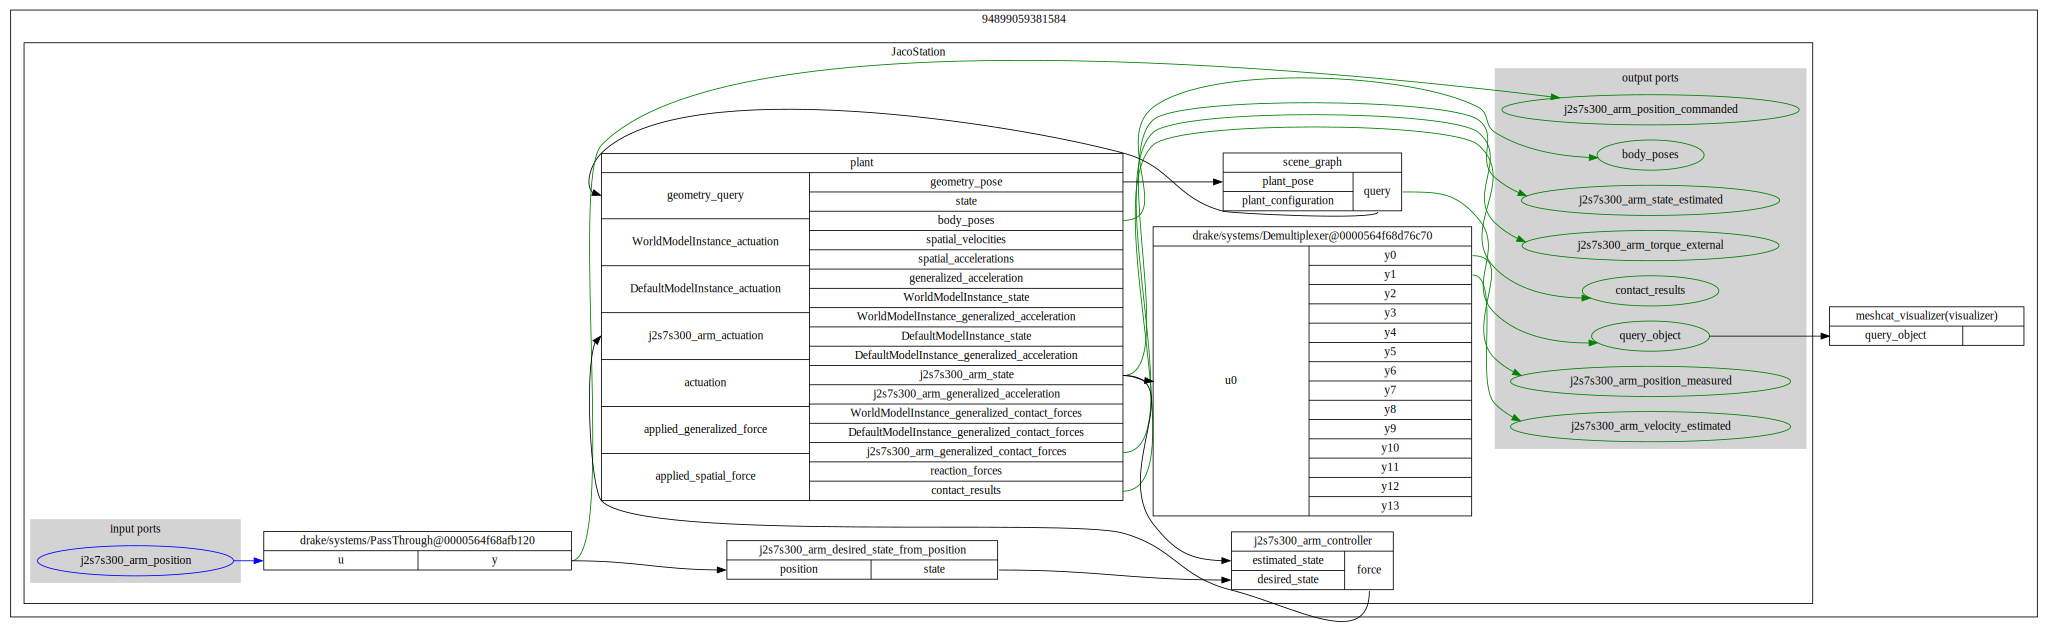

nq: 7
nq: 7
[1.8  3.44 3.14 0.76 4.63 4.49 5.03]


In [138]:
painter = Jaco_Painter(visualize_diagram=True)

In [139]:
X_WG = painter.get_X_WG()
painter.visualize_frame("gripper_current", X_WG)

nq: 7
nq: 7
[1.8  3.44 3.14 0.76 4.63 4.49 5.03]


In [140]:
radius = 0.2
p0 = [0.45, 0.0, 0.4]
R0 = RotationMatrix(np.array([[0, 1, 0], [0, 0, -1], [-1, 0, 0]]).T)
X_WorldCenter = RigidTransform(R0, p0)

num_key_frames = 10
thetas = np.linspace(0, 2 * np.pi, num_key_frames)

In [141]:
def compose_circular_key_frames(thetas, X_WorldCenter, X_WorldGripper_init, radius):
    """
    returns: a list of RigidTransforms
    """
    key_frame_poses_in_world = [X_WorldGripper_init]
    for theta in thetas:
        p_WorldCenter = X_WorldCenter.translation()
        # calculate each coordinates
        # TODO:
        # change radius depending on theta
        p_i = [radius + radius * math.cos(theta), 
               radius + radius * math.sin(theta),
               p_WorldCenter[2]
              ]
        this_pose = RigidTransform(RotationMatrix().MakeZRotation(theta), p_i)
        # TODO:
        key_frame_poses_in_world.append(this_pose)
        
    return key_frame_poses_in_world

In [142]:
def visualize_key_frames(frame_poses):
    for i, pose in enumerate(frame_poses):
        painter.visualize_frame("frame_{}".format(i), pose, length=0.05)
        
key_frame_poses = compose_circular_key_frames(
    thetas, X_WorldCenter, painter.get_X_WG(), radius
)
visualize_key_frames(key_frame_poses)

nq: 7
nq: 7
[1.8  3.44 3.14 0.76 4.63 4.49 5.03]


In [143]:
X_WorldGripper_init = painter.get_X_WG()
total_time = 20
key_frame_poses = compose_circular_key_frames(
    thetas, X_WorldCenter, X_WorldGripper_init, radius
)
times = np.linspace(0, total_time, num_key_frames + 1)
traj = PiecewisePose.MakeLinear(times, key_frame_poses)

nq: 7
nq: 7
[1.8  3.44 3.14 0.76 4.63 4.49 5.03]


In [144]:
painter = Jaco_Painter(traj)

loaded model of WorldModelInstance
loaded model of DefaultModelInstance
loaded model of j2s7s300_arm
num_jaco_positions: 7
nq: 7
nq: 7
[1.8  3.44 3.14 0.76 4.63 4.49 5.03]


In [148]:
painter.paint(sim_duration=total_time)

nq: 7
nq: 7
[1.8  3.44 3.14 0.76 4.63 4.49 5.03]
